In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import trange, tqdm
import joblib

from pcap_processor import calculate_features



In [2]:
# Check if CUDA (NVIDIA's GPU programming toolkit) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. PyTorch cannot use the GPU.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA is available. PyTorch can use the GPU.
Number of GPUs available: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Using device: cuda


In [3]:
# Load the tensors from the .pt files
data_tensors = torch.load('data_tensors_10s_0.01s.pt')
target_tensors = torch.load('target_tensors_10s_0.01s.pt')

print("Data tensors and target tensors loaded successfully!")

# Example usage: Checking the shapes of the loaded tensors
print(f"Number of data samples: {len(data_tensors)}")
print(f"Shape of first data sample: {data_tensors[0].shape}")
print(f"Shape of target tensor: {target_tensors.shape}")

Data tensors and target tensors loaded successfully!
Number of data samples: 3000
Shape of first data sample: torch.Size([1000, 22])
Shape of target tensor: torch.Size([3000])


In [4]:

# Define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.rnn(x)
        out = self.fc(h_n[-1])
        return out


# Define custom dataset
class PacketCaptureDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]



In [5]:
# Normalize the target tensors
target_mean = target_tensors.mean()
target_std = target_tensors.std()

# Make a function to denormalize a prediction
def denormalize(tensor):
    return tensor * target_std + target_mean

target_tensors = (target_tensors - target_mean) / target_std

train_data, test_data, train_targets, test_targets = train_test_split(
    data_tensors, target_tensors, test_size=0.2, random_state=42
)

# Create datasets and data loaders
train_dataset = PacketCaptureDataset(train_data, train_targets)
test_dataset = PacketCaptureDataset(test_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
input_size = len(train_dataset[0][0][0])  # Assuming all packet captures have the same structure
hidden_size = 64
output_size = 1
model = RNNModel(input_size, hidden_size, output_size).to(device)  # Move model to GPU
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [37]:
# FILEPATH: /home/ziv/Desktop/coding/speedtest-research/cs293n/model/lstm.ipynb
model.load_state_dict(torch.load('model_weights_10s_0.01s.pt'))

# at 3250 total so far
num_epochs = 1750

model.train()
with tqdm(total=num_epochs) as pbar:
    prev_loss = float('inf')
    for epoch in range(num_epochs):
        total_loss = 0
        num_batches = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        average_loss = total_loss / num_batches
        pbar.set_description(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
        pbar.update(1)

        prev_loss = average_loss


  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 750, Loss: 0.1115:  30%|███       | 750/2500 [10:00<23:20,  1.25it/s] 


KeyboardInterrupt: 

In [38]:
# save the weights of the model to a file
torch.save(model.state_dict(), 'model_weights_10s_0.01s.pt')

In [39]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate total absolute error
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error: {average_absolute_error}")


Average Absolute Error: 0.1580571218271507


In [40]:
# Initialize variables to calculate total absolute error for denormalized values
total_absolute_error = 0
num_samples = len(test_targets)

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value and denormalize it
        predicted_value = denormalize(model(input_tensor).item())
        actual_value = denormalize(target_value.item())

        # Calculate absolute error
        absolute_error = abs(predicted_value - actual_value)
        total_absolute_error += absolute_error

# Calculate average absolute error
average_absolute_error = total_absolute_error / num_samples
print(f"Average Absolute Error (Denormalized): {average_absolute_error}")


Average Absolute Error (Denormalized): 17.863449096679688


In [41]:
# Initialize list to store absolute errors
absolute_errors = []

with torch.no_grad():  # Disable gradient calculation for inference
    for i in range(num_samples):
        # Move the input and target to the same device as the model
        input_tensor = test_data[i].unsqueeze(0).to(device)
        target_value = test_targets[i].to(device)

        # Get the predicted value
        predicted_value = model(input_tensor).item()
        actual_value = target_value.item()

        # Calculate absolute error and append to list
        absolute_error = abs(predicted_value - actual_value)
        absolute_errors.append(absolute_error)

# Calculate median absolute error
median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error: {median_absolute_error}")

Median Absolute Error: 0.015166312456130981


In [42]:
# get the median absolute error for the denormalized values
absolute_errors = []

for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    absolute_error = abs(predicted_value - actual_value)
    absolute_errors.append(absolute_error)

median_absolute_error = np.median(absolute_errors)
print(f"Median Absolute Error (Denormalized): {median_absolute_error}")


Median Absolute Error (Denormalized): 1.714080810546875


In [43]:
# get the mean square error
total_square_error = 0
for i in range(num_samples):
    predicted_value = model(test_data[i].unsqueeze(0).to(device)).item()
    actual_value = test_targets[i].to(device).item()
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error: {mean_square_error}")


Mean Square Error: 0.4705435245747132


In [44]:
# get the mean square error for the denormalized values
total_square_error = 0
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    square_error = (predicted_value - actual_value) ** 2
    total_square_error += square_error

mean_square_error = total_square_error / num_samples
print(f"Mean Square Error (Denormalized): {mean_square_error}")


Mean Square Error (Denormalized): 6010.38232421875


In [45]:
# print each actual vs prediction value
for i in range(num_samples):
    predicted_value = model(test_data[i].to(device).unsqueeze(0)).item()
    actual_value = test_targets[i].to(device).item()
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: -0.21166448295116425, Predicted: -0.130010724067688
Actual: -0.21323460340499878, Predicted: -0.20670628547668457
Actual: 0.13402138650417328, Predicted: -0.0915302038192749
Actual: -0.2292727828025818, Predicted: -0.22632861137390137
Actual: -0.21166515350341797, Predicted: -0.16826128959655762
Actual: -0.2560468316078186, Predicted: -0.24806702136993408
Actual: -0.24280256032943726, Predicted: -0.23879027366638184
Actual: -0.2118397206068039, Predicted: -0.2075108289718628
Actual: -0.2565232217311859, Predicted: -0.2511463165283203
Actual: -0.2520920932292938, Predicted: -0.2543191909790039
Actual: -0.25963708758354187, Predicted: -0.25631678104400635
Actual: -0.2595170736312866, Predicted: -0.25874781608581543
Actual: -0.22725093364715576, Predicted: -0.2000945806503296
Actual: -0.23798316717147827, Predicted: -0.23114824295043945
Actual: 3.107248306274414, Predicted: 0.18369746208190918
Actual: 7.124375820159912, Predicted: 2.5029587745666504
Actual: 0.36677077412605286, Pr

In [46]:
# print each actual vs prediction value for denormalized values
for i in range(num_samples):
    predicted_value = denormalize(model(test_data[i].unsqueeze(0).to(device)).item())
    actual_value = denormalize(test_targets[i].to(device).item())
    print(f"Actual: {actual_value}, Predicted: {predicted_value}")

Actual: 5.705404281616211, Predicted: 14.933821678161621
Actual: 5.527950286865234, Predicted: 6.265773773193359
Actual: 44.774436950683594, Predicted: 19.282848358154297
Actual: 3.715333938598633, Predicted: 4.0480804443359375
Actual: 5.705327987670898, Predicted: 10.610784530639648
Actual: 0.6893596649169922, Predicted: 1.5912303924560547
Actual: 2.1862125396728516, Predicted: 2.639677047729492
Actual: 5.685598373413086, Predicted: 6.174844741821289
Actual: 0.6355190277099609, Predicted: 1.2432117462158203
Actual: 1.1363201141357422, Predicted: 0.8846168518066406
Actual: 0.28359413146972656, Predicted: 0.6588516235351562
Actual: 0.29715728759765625, Predicted: 0.3840980529785156
Actual: 3.9438400268554688, Predicted: 7.013021469116211
Actual: 2.73089599609375, Predicted: 3.5033702850341797
Actual: 380.8052673339844, Predicted: 50.388771057128906
Actual: 834.8165283203125, Predicted: 312.5091247558594
Actual: 71.07951354980469, Predicted: 19.001895904541016
Actual: 1.177499771118164, 

In [47]:
# Calculate the average percentage error of the model
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error: {average_percentage_error}%")

# Print the standard deviation of the percentage errors
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors: {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%): {percentage_errors_std}")


Average Percentage Error: 104.58615351313708%
Standard Deviation of Percentage Errors: 5.070272636957683
Average Percentage Error (Without Top 2%): 31.41806411743164%
Standard Deviation of Percentage Errors (Without Top 2%): 5.107205494541153


In [48]:
# Calculate the average percentage error of the model for denormalized values
total_percentage_error = 0
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    total_percentage_error += percentage_error

average_percentage_error = (total_percentage_error / num_samples) * 100
print(f"Average Percentage Error (Denormalized): {average_percentage_error}%")

# Print the standard deviation of the percentage errors for denormalized values
percentage_errors = []  
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Denormalized): {percentage_errors_std}")

# Remove the max 2 percent of the errors and calculate the average percentage error for denormalized values
sorted_errors = sorted(absolute_errors)
num_samples_to_remove = int(num_samples * 0.02)
sorted_errors = sorted_errors[:-num_samples_to_remove]
average_percentage_error = (sum(sorted_errors) / len(sorted_errors)) / target_mean
print(f"Average Percentage Error (Without Top 2%, Denormalized): {average_percentage_error * 100}%")

# Print the standard deviation of the percentage errors for denormalized values (without top 2%)
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)

percentage_errors = np.array(percentage_errors)
percentage_errors = percentage_errors[:-num_samples_to_remove]
percentage_errors_std = np.std(percentage_errors)
print(f"Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): {percentage_errors_std}")


Average Percentage Error (Denormalized): 188.36474609375%
Standard Deviation of Percentage Errors (Denormalized): 5.346930980682373
Average Percentage Error (Without Top 2%, Denormalized): 31.41806411743164%
Standard Deviation of Percentage Errors (Without Top 2%, Denormalized): 5.398070335388184


In [49]:
# Calculate the median percentage error of the model
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = model(input_tensor).item()
    actual_value = target_value.item()
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error: {median_percentage_error}%")


Median Percentage Error: 6.987946477750853%


In [50]:
# Calculate the median percentage error of the model for denormalized values
percentage_errors = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    percentage_error = abs(predicted_value - actual_value) / abs(actual_value)
    percentage_errors.append(percentage_error)
    if percentage_error < 0:
        print(f"Predicted: {predicted_value}, Actual: {actual_value}, PE: {percentage_error}")

median_percentage_error = np.median(percentage_errors) * 100
print(f"Median Percentage Error (Denormalized): {median_percentage_error}%")


Median Percentage Error (Denormalized): 59.168803691864014%


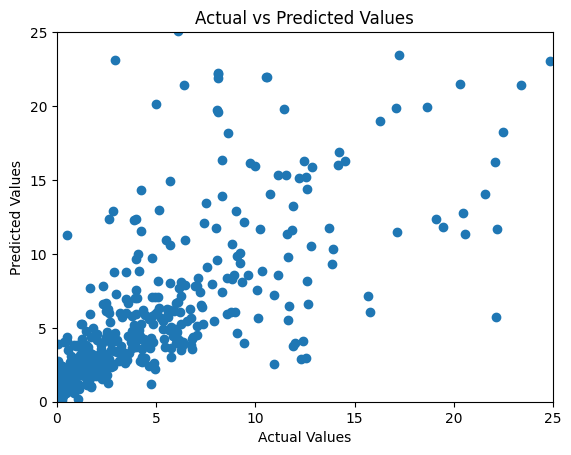

In [51]:
# Plot the denormalized values for the actual and predicted values on the testing set

import matplotlib.pyplot as plt

actual_values = []
predicted_values = []
for i in range(num_samples):
    # Move the input and target to the same device as the model
    input_tensor = test_data[i].unsqueeze(0).to(device)
    target_value = test_targets[i].to(device)

    predicted_value = denormalize(model(input_tensor).item())
    actual_value = denormalize(target_value.item())
    actual_values.append(actual_value)
    predicted_values.append(predicted_value)

plt.scatter(actual_values, predicted_values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlim(0, 25)
plt.ylim(0, 25)
plt.show()
